In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from dataloader import get_data, get_data_3d
from sklearn.model_selection import train_test_split

In [2]:
tf.test.is_gpu_available()

True

In [229]:
np.math.factorial(12)

479001600

In [230]:
def taylor_sin(x):
    return x - tf.pow(x, 3)/6. + tf.pow(x, 5)/120. - tf.pow(x, 7)/5040.

def taylor_cos(x):
    return 1 - tf.pow(x, 2)/2. + tf.pow(x, 4)/24. - tf.pow(x, 6)/720. + tf.pow(x, 8)/40320. - tf.pow(x, 10)/3628800. + tf.pow(x, 12)/479001600.

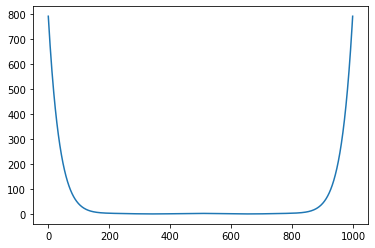

In [231]:
x = np.linspace(-10,10,1000)
tc = taylor_cos(x)
plt.plot(tc)

In [327]:
def ad(zen_true, az_true, zen_pred, az_pred):
    dd = tf.math.cos(zen_pred) * tf.math.cos(zen_true) + tf.math.sin(zen_pred) * tf.math.sin(zen_true) * tf.math.cos(az_pred - az_true)
    dd = tf.clip_by_value(dd, -1., 1.)
    return tf.math.acos(dd)

In [328]:
def angular_dist(zen_true, az_true, zen_pred, az_pred):
    
    dist = ad(zen_true, az_true, zen_pred, az_pred)
    
    
    # penalty term for wrong branch
    
    az_dist = tf.abs((az_true - az_pred))
    az_mask = tf.dtypes.cast((az_dist > np.pi), dtype=dist.dtype)
    az_penalty = az_mask * (az_dist)
                             
    zen_dist = tf.abs((zen_true - zen_pred))
    zen_mask = tf.dtypes.cast((zen_dist > 0.5 * np.pi), dtype=dist.dtype)
    zen_penalty = zen_mask * (zen_dist)
                     
    dist_mask = (1. - az_mask) * (1. - zen_mask)
    
    
    #az_b = tf.abs(((az_true - az_pred) + np.pi) // (2 * np.pi)) == 0.
    #zen_b =  tf.abs(zen_true - zen_pred) // (0.5 * np.pi) == 0.
    
    return dist * dist_mask + (1 - dist_mask) * (az_penalty + zen_penalty)
    
    
    #dd = taylor_sin(zen_pred) * tf.math.sin(zen_true) + taylor_cos(zen_pred) * tf.math.cos(zen_true) * tf.math.cos(az_pred - az_true)

    #return dd
    
    # if angular distance > pi / 2 -> extend loss at pi/2 linearly in az and zen
    
    az_dist = tf.abs((az_true - az_pred) * tf.abs(tf.math.cos(zen_true)))
    #az_dist = tf.maximum(az_dist, np.pi) - np.pi
    
    
    zen_dist = tf.abs(zen_true - zen_pred) * (1 + tf.abs(tf.math.sin(zen_true))) * 0.5
    #zen_dist = tf.maximum(zen_dist, 0.5 * np.pi) - 0.5 * np.pi
    
    lin_term = tf.sqrt(tf.square(az_dist) + tf.square(zen_dist)) #- 0.5 * np.pi
    
    return lin_term
    
    #mask = tf.dtypes.cast((dist > 0.5 * np.pi) | (lin_term > 0.25 * np.pi) , dtype=dist.dtype)
    
    #dist = dist * ( 1. - mask) + mask * lin_term
    
    #masked_dist = tf.boolean_mask(dist, mask)
    
    #masked_dist = masked_dist + tf.boolean_mask(lin_term, mask)
    
    return dist

    

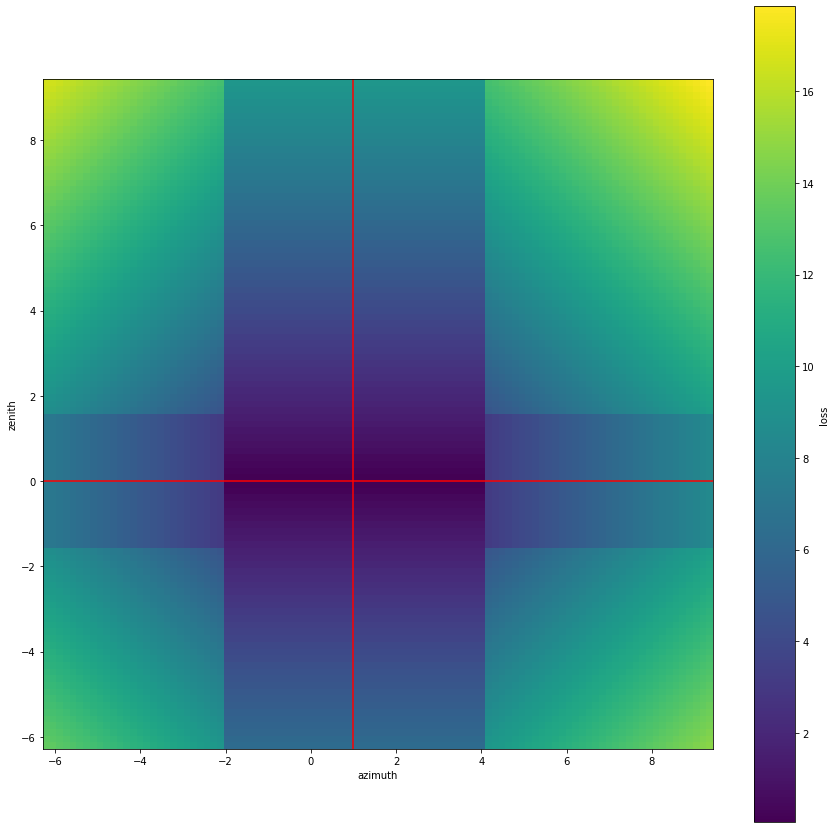

In [289]:
zenith = np.linspace(-2*np.pi, 3*np.pi, 100)
azimuth = np.linspace(-2*np.pi, 3*np.pi, 100)

zenzen, azaz = np.meshgrid(zenith, azimuth)

true = [0, 1]

loss = angular_dist(np.array(true[0], dtype=np.float64), np.array(true[1], dtype=np.float64), zenzen.T, azaz.T)

fig, ax = plt.subplots(1, 1, figsize=(15,15))
im = ax.imshow(loss, extent=(azimuth[0], azimuth[-1], zenith[0], zenith[-1]), origin='lower')
ax.axhline(true[0], color='r')
ax.axvline(true[1], color='r')

ax.set_xlabel('azimuth')
ax.set_ylabel('zenith')

cbar = fig.colorbar(im, )
cbar.set_label('loss')

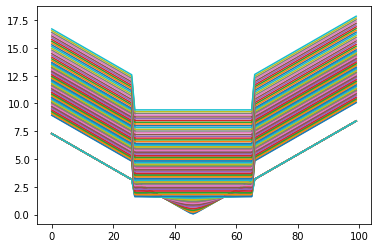

In [277]:
plt.plot(np.asarray(loss).T);

In [109]:
def my_loss(y_true, y_pred, sample_weight=1.):

    # vertex

    #if sample_weight is None:
    #sample_weight = 1.

    dist = tf.math.sqrt(tf.square(y_pred[:,0] - y_true[:,0]) / 25. + tf.square(y_pred[:,1] - y_true[:,1]) / 25. + tf.square(y_pred[:,2] - y_true[:,2]) / 15.) / 3.
    # Huber
    delta = 1.
    mask = dist < delta
    p1 = 0.5 * tf.square(dist[mask])
    p2 = delta * (dist[~mask] - 0.5*delta)

    vertex_loss =  tf.reduce_mean(tf.concat([p1, p2], axis=0)  )# * sample_weight)

    ad = angular_dist(y_true[:,3], y_true[:,4], y_pred[:,3], y_pred[:, 4])

    #angular_loss = tf.sqrt(tf.reduce_mean(tf.square(ad))) * 2.

    angular_loss = tf.reduce_mean(tf.abs(ad) )#* sample_weight)

    #angular_loss = tf.reduce_mean(tf.math.square(tf.math.acos(tf.math.cos(y_pred[:,3]) * tf.math.cos(y_true[:,3]) + tf.math.sin(y_pred[:,3]) * tf.math.sin(y_true[:,3]) * tf.math.cos(y_pred[:,4] - y_true[:,4]))), axis=0)

    energy_loss = tf.sqrt(tf.reduce_mean(tf.math.square(y_pred[:,5] - y_true[:,5]) ))#* sample_weight)) / 50.

    return energy_loss + angular_loss + vertex_loss   #vertex_loss + angular_loss + energy_loss

In [344]:
def my_loss(y_true, y_pred, sample_weight=1.):

    # vertex

    #if sample_weight is None:
    #sample_weight = 1.

    dist = tf.math.sqrt(tf.square((y_pred[:,0] - y_true[:,0])/25.)  + tf.square((y_pred[:,1] - y_true[:,1])/25.)  + tf.square((y_pred[:,2] - y_true[:,2]))/15.)
    # Huber
    delta = 1.
    mask = dist < delta
    p1 = 0.5 * tf.square(dist[mask])
    p2 = delta * (dist[~mask] - 0.5*delta)

    vertex_loss =  tf.concat([p1, p2], axis=0)

    ad = angular_dist(y_true[:,3], y_true[:,4], y_pred[:,3], y_pred[:, 4])

    #angular_loss = tf.sqrt(tf.reduce_mean(tf.square(ad))) * 2.

    angular_loss = tf.abs(ad) 

    #angular_loss = tf.reduce_mean(tf.math.square(tf.math.acos(tf.math.cos(y_pred[:,3]) * tf.math.cos(y_true[:,3]) + tf.math.sin(y_pred[:,3]) * tf.math.sin(y_true[:,3]) * tf.math.cos(y_pred[:,4] - y_true[:,4]))), axis=0)
    
    energy_loss = tf.math.abs(y_pred[:,5] - y_true[:,5]) / y_true[:,5]

    return (energy_loss + angular_loss + vertex_loss) * sample_weight   #vertex_loss + angular_loss + energy_loss

In [56]:
X, y = get_data(
    '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000120.hdf5',
    features = ['charge'],
    labels = ['z'],
    sparse=True,
    ragged=False,
    N_events=2,
    )

N_events, N_channels, max_pulses, N_features = X.shape
_, N_labels = y.shape

100%|██████████| 2/2 [00:00<00:00, 405.66it/s]

max pulses =  146


In [11]:
labels = ['x', 'y', 'z', 'zenith', 'azimuth', 'energy']

In [338]:
X, y = get_data_3d(
    '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000060.hdf5',
    features = ["np.sum(p['charge'])", "len(p)", "np.min(p['time'])", "np.median(p['time'])", "np.max(p['time'])"],
    labels = labels,
    N_events=None,
    )


# at least 8 pulses
w = np.sum(X[:,:,1], axis=1)

mask = w >= 8

X = X[mask]
y = y[mask]
w = w[mask]

N_events, N_channels, N_features = X.shape
_, N_labels = y.shape

100%|██████████| 13828/13828 [01:25<00:00, 162.34it/s]


In [339]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.1, random_state=42)

In [332]:
#model = tf.keras.Sequential()

# Todo: split up IC and DC strings!


# d1=16
# d2=16
# d3=16
# d4=16
# d5=16
# d6=128

d_lstm = 1

activation=tf.nn.leaky_relu
#activation='relu'

max_pulses=None

#model.add(tf.keras.Input(shape=(N_channels, None, N_features)))#, ragged=True))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(d1, activation=activation, input_shape=(None, N_features)), input_shape=(N_channels, None, N_features)))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d2, activation=activation), input_shape=(N_channels, d1)))


# with LSTM
#inputs = tf.keras.Input(shape=(N_channels, max_pulses, N_features))#, sparse=True)
#h0 = tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(d_lstm, activation='relu', input_shape=(max_pulses, N_features)), input_shape=(N_channels, max_pulses, N_features), )(inputs, )

# without LSTM, simple sum over time
inputs = tf.keras.Input(shape=(N_channels, N_features))
h0 = inputs

h1 = tf.keras.layers.Reshape((86, 60 * N_features))(h0)

h2 = tf.keras.layers.Dropout(0.005)(h1)


ic = tf.keras.layers.Lambda(lambda x: x[:, :78])(h2)
dc = tf.keras.layers.Lambda(lambda x: x[:, 78:])(h2)


h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation=activation, input_shape=(60 * d_lstm,)), input_shape=(78,60 * d_lstm))(ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation=activation, input_shape=(60 * d_lstm,)), input_shape=(8,60 * d_lstm))(dc)

n2 = 16
h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n2, activation=activation, input_shape=(16,)), input_shape=(78,16))(h_ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n2, activation=activation, input_shape=(16,)), input_shape=(78,16))(h_dc)


h3 = tf.keras.layers.Concatenate(axis=1)([h_ic, h_dc])

h4 = tf.keras.layers.Flatten(input_shape=(86, n2))(h3)

h4 = tf.keras.layers.Dropout(0.01)(h4)

h5 = tf.keras.layers.Dense(32, activation=activation)(h4)
h5 = tf.keras.layers.Dropout(0.01)(h5)
h5 = tf.keras.layers.Dense(32, activation=activation)(h5)


outputs = tf.keras.layers.Dense(N_labels, activation='linear')(h5)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()


#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d1, activation=activation), input_shape=(N_channels, N_features)))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d2, activation=activation), input_shape=(N_channels, d1)))
#model.add(tf.keras.layers.Reshape((86, 60 * d2)))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d3, activation=activation, input_shape=(60*d2,)), input_shape=(86,60*d2)))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d4, activation=activation, input_shape=(d3,)), input_shape=(86,d3)))
#model.add(tf.keras.layers.Flatten(input_shape=(86, d4)))
#model.add(tf.keras.layers.Dense(d5, activation='activation))
#model.add(tf.keras.layers.Dense(d6))

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 5160, 5)]    0                                            
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 86, 300)      0           input_13[0][0]                   
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 86, 300)      0           reshape_12[0][0]                 
__________________________________________________________________________________________________
lambda_24 (Lambda)              (None, 78, 300)      0           dropout_36[0][0]                 
___________________________________________________________________________________________

In [346]:
#optimizer = tf.keras.optimizers.SGD(0.001, clipnorm=1) # bad
#optimizer = tf.keras.optimizers.RMSprop(0.001, )
optimizer = tf.keras.optimizers.Nadam(0.01, clipnorm=1.)

#model.compile(loss=angular_dist_loss, optimizer="sgd", )
model.compile(loss=my_loss, optimizer=optimizer)

In [347]:
# sample_weights_train = np.log(w_train)
# sample_weights_test = np.log(w_test)

sample_weights_train = np.ones_like(w_train)
sample_weights_test = np.ones_like(w_test)

In [348]:
model.fit(X_train, y_train, sample_weight=sample_weights_train, batch_size=512, epochs=50, validation_data=(X_test, y_test, sample_weights_test), )
#model.fit(X_train, y_train, sample_weight=w_train, batch_size=512, epochs=10, validation_data=(X_test, y_test), )

Train on 9683 samples, validate on 1076 samples
Epoch 1/50
9683/9683 [==============================] - 3s 278us/sample - loss: 63.4766 - val_loss: 32.6699
Epoch 2/50
9683/9683 [==============================] - 1s 74us/sample - loss: 29.4134 - val_loss: 21.0757
Epoch 3/50
9683/9683 [==============================] - 1s 62us/sample - loss: 21.4730 - val_loss: 17.5384
Epoch 4/50
9683/9683 [==============================] - 1s 60us/sample - loss: 19.4905 - val_loss: 21.2312
Epoch 5/50
9683/9683 [==============================] - 1s 63us/sample - loss: 18.7050 - val_loss: 16.9291
Epoch 6/50
9683/9683 [==============================] - 1s 55us/sample - loss: 17.4642 - val_loss: 17.0817
Epoch 7/50
9683/9683 [==============================] - 1s 59us/sample - loss: 16.6210 - val_loss: 16.8621
Epoch 8/50
9683/9683 [==============================] - 1s 61us/sample - loss: 15.8445 - val_loss: 17.0344
Epoch 9/50
9683/9683 [==============================] - 1s 58us/sample - loss: 14.9452 - val_lo

x : width =  44.02921009063721  median =  0.060608863830566406
y : width =  42.263737201690674  median =  2.946354866027832
z : width =  37.64179229736328  median =  19.717056274414062
zenith : width =  1.8885842263698578  median =  -2.4543377161026
azimuth : width =  3.3193925321102142  median =  0.12629377841949463
energy : width =  85.29303860664368  median =  -21.31386947631836


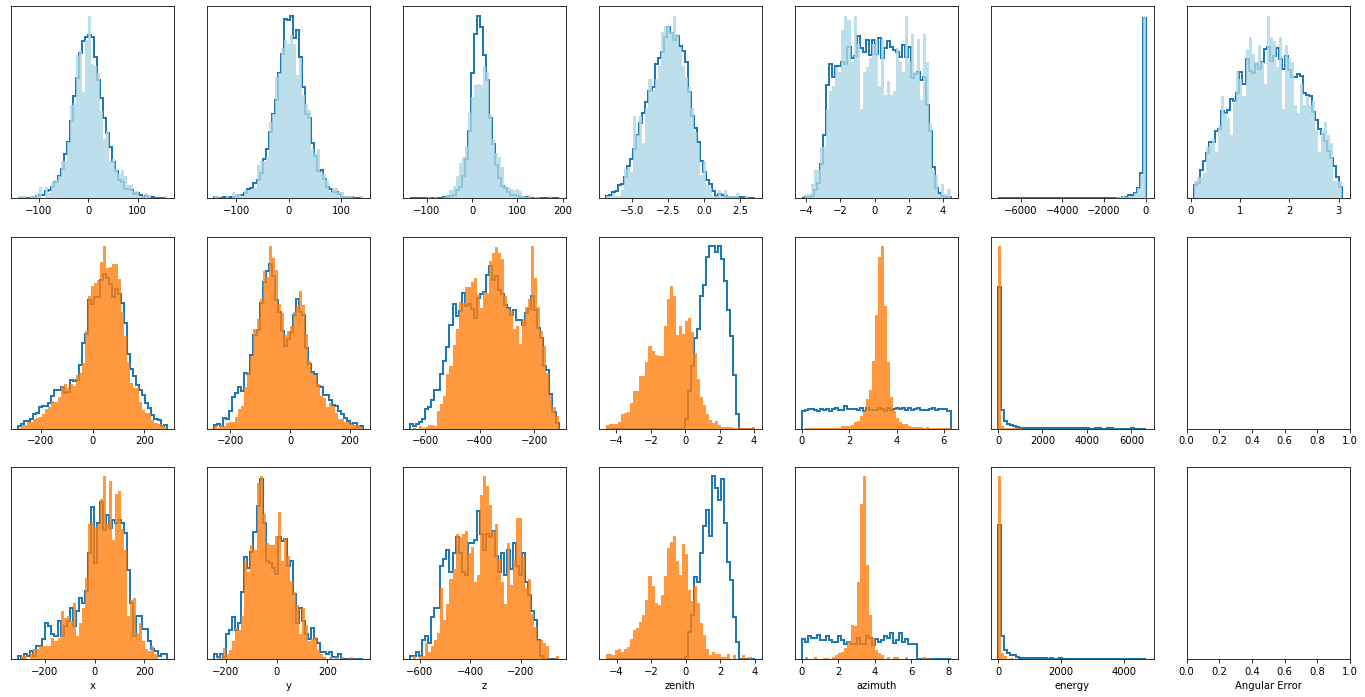

In [349]:
y_pred_test = model.predict(X_test, batch_size=64)
y_pred_train = model.predict(X_train, batch_size=64)


# if 'azimuth' in labels:
#     idx = labels.index('azimuth')
#     y_pred_test[:,idx] = y_pred_test[:,idx] % (2 * np.pi)
#     y_pred_train[:,idx] = y_pred_train[:,idx] % (2 * np.pi)

# if 'zenith' in labels:
#     idx = labels.index('zenith')
#     y_pred_test[:,idx] = y_pred_test[:,idx] % (2 * np.pi)
#     y_pred_test[:,idx][y_pred_test[:,idx] > np.pi] = 2 * np.pi - y_pred_test[:,idx][y_pred_test[:,idx] > np.pi]

#     y_pred_train[:,idx] = y_pred_train[:,idx] % (2 * np.pi)
#     y_pred_train[:,idx][y_pred_train[:,idx] > np.pi] = 2 * np.pi - y_pred_train[:,idx][y_pred_train[:,idx] > np.pi]

    
err_test = y_pred_test - y_test
err_train = y_pred_train - y_train


#plot_weights_train = np.log(w_train)
#plot_weights_test = np.log(w_test)


plot_weights_train = sample_weights_train
plot_weights_test =sample_weights_test


if 'azimuth' in labels and 'zenith' in labels:
    N_subplots = N_labels + 1
else:
    N_subplots = N_labels

fig, ax = plt.subplots(nrows=3, ncols=N_subplots, figsize=(24,12))
    
qs = [0.001, 0.999]
    
for i in range(N_labels):    
    lo, up = np.quantile(np.concatenate([err_train[:,i], err_test[:,i]]), qs)
    bins = np.linspace(lo, up, 50)
    
    ax[0, i].hist(err_train[:,i], bins=bins, histtype='step', lw=2, density=True, weights=plot_weights_train)
    ax[0, i].hist(err_test[:,i], bins=bins, alpha=0.8, density=True, color='lightblue', weights=plot_weights_test)
    ax[0, i].get_yaxis().set_visible(False)

    lo, up = np.quantile(np.concatenate([y_pred_train[:,i], y_train[:,i]]), qs)
    bins = np.linspace(lo, up, 50)
    ax[1, i].hist(y_train[:,i], bins=bins, histtype='step', lw=2, density=True, weights=plot_weights_train)
    ax[1, i].hist(y_pred_train[:,i], bins=bins, alpha=0.8, density=True, weights=plot_weights_train) 
    ax[1, i].get_yaxis().set_visible(False)

    lo, up = np.quantile(np.concatenate([y_pred_test[:,i], y_test[:,i]]), qs)
    bins = np.linspace(lo, up, 50)
    ax[2, i].hist(y_test[:,i], bins=bins, histtype='step', lw=2, density=True, weights=plot_weights_test)
    ax[2, i].hist(y_pred_test[:,i], bins=bins, alpha=0.8, density=True, weights=plot_weights_test)  
    ax[2, i].get_yaxis().set_visible(False)
    ax[2, i].set_xlabel(labels[i])
    
    q25, q50, q75 = np.quantile(err_test[:,i], [0.25, 0.5, 0.75])
    print(labels[i], ': width = ', q75 - q25, ' median = ',q50)
    
    
    
if N_subplots > N_labels:
    
    az_idx = labels.index('azimuth')
    zen_idx = labels.index('zenith')
    
    ad_error_train = ad(y_train[:, zen_idx], y_train[:, az_idx], y_pred_train[:, zen_idx], y_pred_train[:, az_idx])
    ad_error_test = ad(y_test[:, zen_idx], y_test[:, az_idx], y_pred_test[:, zen_idx], y_pred_test[:, az_idx])
    
    lo, up = np.quantile(np.concatenate([ad_error_train, ad_error_test]), qs)
    bins = np.linspace(lo, up, 50)
    
    ax[0, -1].hist(ad_error_train, bins=bins, histtype='step', lw=2, density=True, weights=plot_weights_train)
    ax[0, -1].hist(ad_error_test, bins=bins, alpha=0.8, density=True, color='lightblue', weights=plot_weights_test)
    ax[0, -1].get_yaxis().set_visible(False)   
    ax[1, -1].get_yaxis().set_visible(False)
    ax[2, -1].get_yaxis().set_visible(False)
    
    ax[2, -1].set_xlabel('Angular Error')

In [299]:
ad_test = angular_dist(y_test[:,3], y_test[:,4], y_pred_test[:,3], y_pred_test[:,4])
ad_train = angular_dist(y_train[:,3], y_train[:,4], y_pred_train[:,3], y_pred_train[:,4])

In [300]:
np.mean(y_pred_test[:,4])

3.191351

In [301]:
np.max(ad_test)

36.229504

(array([2.69675507e-01, 6.02773243e-03, 5.24150612e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.62075237e-04]),
 array([ 0.06176147,  3.6785357 ,  7.29531   , 10.912085  , 14.528858  ,
        18.145632  , 21.762407  , 25.37918   , 28.995955  , 32.61273   ,
        36.229504  ], dtype=float32),
 <a list of 10 Patch objects>)

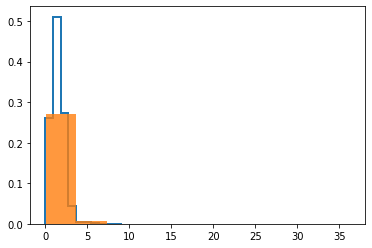

In [302]:
plt.hist(ad_train, histtype='step', lw=2, density=True)
plt.hist(ad_test, alpha=0.8, density=True)

In [784]:
np.mean(ad_test) * 2
#np.mean(ad_train) * 2

2.4338836669921875

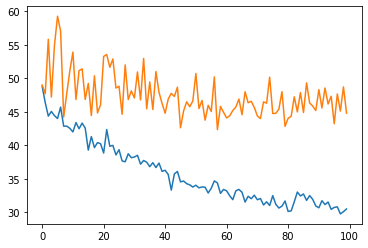

In [32]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [1065]:
model.weights

[<tf.Variable 'time_distributed_184/kernel:0' shape=(300, 64) dtype=float32>,
 <tf.Variable 'time_distributed_184/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'time_distributed_185/kernel:0' shape=(300, 64) dtype=float32>,
 <tf.Variable 'time_distributed_185/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'time_distributed_186/kernel:0' shape=(64, 16) dtype=float32>,
 <tf.Variable 'time_distributed_186/bias:0' shape=(16,) dtype=float32>,
 <tf.Variable 'time_distributed_187/kernel:0' shape=(64, 16) dtype=float32>,
 <tf.Variable 'time_distributed_187/bias:0' shape=(16,) dtype=float32>,
 <tf.Variable 'dense_327/kernel:0' shape=(1376, 32) dtype=float32>,
 <tf.Variable 'dense_327/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'dense_328/kernel:0' shape=(32, 32) dtype=float32>,
 <tf.Variable 'dense_328/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'dense_329/kernel:0' shape=(32, 6) dtype=float32>,
 <tf.Variable 'dense_329/bias:0' shape=(6,) dtype=float32>]